### Import Libraries

In [1]:
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import statsmodels.api as sm

### Anti-Diagonal Averaging Function

In [2]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

### Load Audio File and Plot

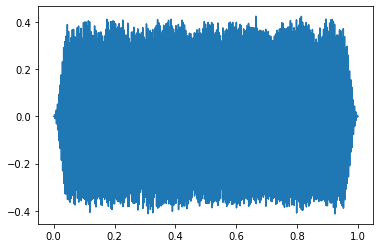

In [3]:
y, sr = librosa.load('klattSyn.wav', sr=11000)
t=np.linspace(0, (y.shape[0]-1),y.shape[0])/sr

plt.plot(t,y)
plt.show()

### Clip a Suitable Portion

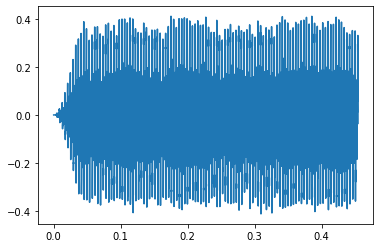

In [4]:
# This part may not be requird.
# If it's required, save the clipped portion in a separate audio file
y_tran=y[0:5000]
t_tran=t[0:5000]
plt.plot(t_tran,y_tran)
plt.show()

### Hankel Matrix Representation

In [5]:
N=y_tran.shape[0]
L = 2000 # The window length.
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
audio_data = np.column_stack([y_tran[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive.

### Apply SVD and Calculate the Elementary Matrices

In [6]:
d=10
U, Sigma, V = np.linalg.svd(audio_data, full_matrices=False)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

### Plot First Few Components

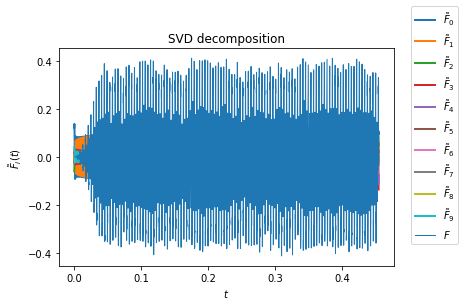

In [7]:
fig = plt.subplot()
for i in range(d):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t_tran, F_i, lw=2)

fig.axes.plot(t_tran, y_tran, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(d)] + ["$F$"]
fig.set_title("SVD decomposition")
fig.legend(legend, loc=(1.05,0.1));

### Cross Correlate with Original

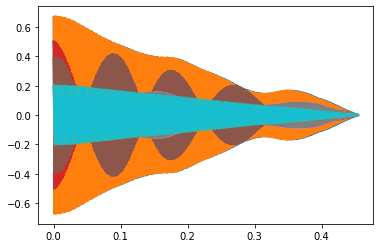

In [8]:
fig = plt.subplot()
for i in range(d):
    F_i = X_to_TS(X_elem[i])
    cross_corr=sm.tsa.stattools.ccf(y_tran, F_i, adjusted=False)
    fig.axes.plot(t_tran, cross_corr, lw=2)
    
plt.show()

### Reconstructed Components

### Compare with Original

### Save Audio File